# Оптимизация процесса обработки стали

# Описание проекта 

Заказчиком почлены данные по процессу обработки стали для разных партий. Для оптимизации производства и уменьшении потребления электроэнергии необходимо построить модель, которая будет предсказывть температуру стали после обработки.

Процесс обработки состоит из нагрева, добавления сыпучих материалов, легирования. Данный процесс может повторять несколько раз до достижения требуемой температуры. 


## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import optuna

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

# 1.Исследовательский анализ данных

## 1.1 Данные об электродах

In [4]:
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


4.628500311138768


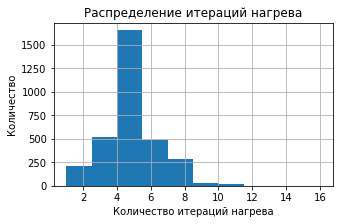

In [6]:
plt.figure()
ax = data_arc['key'].value_counts().hist(figsize=(5,3))
ax.set_title('Распределение итераций нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Количество итераций нагрева')
print(data_arc['key'].value_counts().mean())

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Text(0.5, 0, 'Активная мощность')

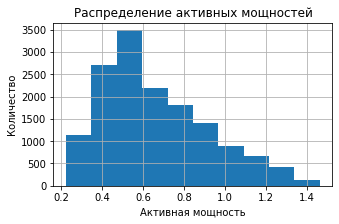

In [9]:
plt.figure()
ax = data_arc['Активная мощность'].hist(figsize=(5,3))
ax.set_title('Распределение активных мощностей')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')

Text(0.5, 0, 'Реактивная мощность')

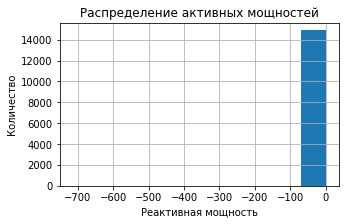

In [10]:
plt.figure()
ax = data_arc['Реактивная мощность'].hist(figsize=(5,3))
ax.set_title('Распределение активных мощностей')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')

In [11]:
data_arc['Реактивная мощность'].sort_values().head()

9780    -715.479924
709        0.153777
3290       0.153921
11794      0.155221
6130       0.156525
Name: Реактивная мощность, dtype: float64

Text(0, 0.5, 'Реактивная мощность')

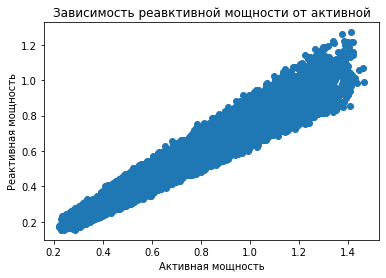

In [12]:
plt.scatter(data_arc.drop(9780)['Активная мощность'], data_arc.drop(9780)['Реактивная мощность'] )
plt.title('Зависимость реавктивной мощности от активной')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность')

<b>Вывод:</b>
  - В столбце 'Реактивная мощность' присутствует аномальное значение. Так же замечена линейная связь между Активной и реактивной мощностью. По уравнению прямой можно найти значение реактивной мощности по значению активной мощности
  - Среднее количество итераций 5

## 1.2 Данные о подаче сыпучих материалов

In [13]:
data_bulk.head() 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [15]:
data_bulk.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk_time.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Text(0.5, 0, 'Тип сыпучего материала')

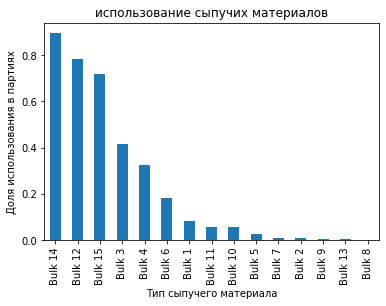

In [17]:
plt.figure()
ax = data_bulk.notna().drop('key', axis=1).mean().sort_values(ascending=False).plot(kind='bar')
ax.set_title('использование сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')

In [18]:
data_bulk.notna().mean() == data_bulk_time.notna().mean()

key        True
Bulk 1     True
Bulk 2     True
Bulk 3     True
Bulk 4     True
Bulk 5     True
Bulk 6     True
Bulk 7     True
Bulk 8     True
Bulk 9     True
Bulk 10    True
Bulk 11    True
Bulk 12    True
Bulk 13    True
Bulk 14    True
Bulk 15    True
dtype: bool

<b>Вывод:</b>
- Структура таблиц одинаковая(нет несоответсвий пропущенных значений между первой и второй таблицей) . 
- Признаки Bulk 11,10,5,7,2,9,13,8 используются в менее 8% партий, данные признаки можно исключить из данных.Данные признаки окажут отрицательное влияние на предсказание модели
- Необходимо изменить тип данных на datetime

## 1.3 Данные о проволочных материалах

In [19]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [22]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Text(0.5, 0, 'Тип проволочного материала')

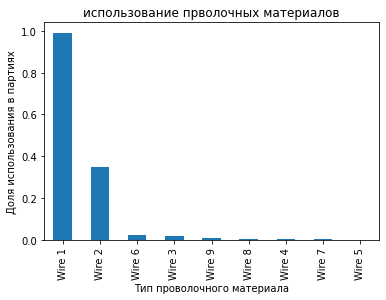

In [23]:
plt.figure()
ax = data_wire.notna().drop('key', axis=1).mean().sort_values(ascending=False).plot(kind='bar')
ax.set_title('использование прволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')

In [24]:
data_wire.notna().mean() == data_wire_time.notna().mean()

key       True
Wire 1    True
Wire 2    True
Wire 3    True
Wire 4    True
Wire 5    True
Wire 6    True
Wire 7    True
Wire 8    True
Wire 9    True
dtype: bool

<b>Вывод:</b>
- Структура таблиц одинаковая(нет несоответсвий пропущенных значений между первой и второй таблицей) . 
- Признаки wire 6,3,9,8,4,7,5 используются в менее 3% партий, данные признаки можно исключить из данных.Данные признаки окажут отрицательное влияние на предсказание модели
- Необходимо изменить тип данных на datetime

## 1.4 Данные о продувке сплава газом

In [25]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Text(0.5, 0, 'Значение показателя Газ')

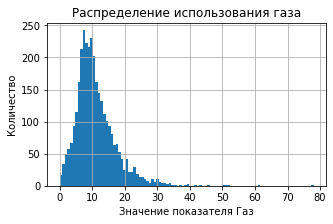

In [27]:
plt.figure()
ax = data_gas['Газ 1'].hist(bins=100, figsize=(5,3))
ax.set_title('Распределение использования газа')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение показателя Газ')

In [28]:
data_gas[data_gas['Газ 1'] > 40]

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


<b>Вывод:</b>
- В выбросах данных нет. Значения выше 40 единичные, данные значение удалять нельзя т.к это выжные данные для определенных партий

## 1.3 Результаты измерения температуры

In [29]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [30]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Text(0.5, 0, 'Значение температуры')

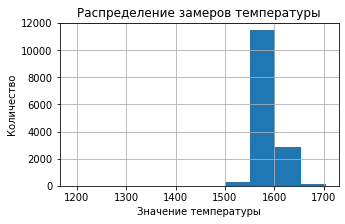

In [31]:
plt.figure()
ax = data_temp['Температура'].hist(figsize=(5,3))
ax.set_title('Распределение замеров температуры')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение температуры')

In [32]:
pd.pivot_table(data_temp, index=['key', 'Время замера']).head(20)

Температура
key Время замера                    
1   2019-05-03 11:02:04       1571.0
    2019-05-03 11:07:18       1604.0
    2019-05-03 11:11:34       1618.0
    2019-05-03 11:18:04       1601.0
    2019-05-03 11:25:59       1606.0
    2019-05-03 11:30:38       1613.0
2   2019-05-03 11:34:04       1581.0
    2019-05-03 11:38:40       1577.0
    2019-05-03 11:46:09       1589.0
    2019-05-03 11:49:38       1604.0
    2019-05-03 11:55:09       1602.0
3   2019-05-03 12:06:44       1596.0
    2019-05-03 12:13:42       1597.0
    2019-05-03 12:18:46       1598.0
    2019-05-03 12:25:33       1599.0
    2019-05-03 12:31:04       1600.0
    2019-05-03 12:35:57       1599.0
4   2019-05-03 12:39:27       1601.0
    2019-05-03 12:44:37       1623.0
    2019-05-03 12:48:04       1618.0

In [33]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


<b>Вывод:</b>
- В столбце температура присутствуют нулевые значения.
- В данной таблице выбросы отсутстуют

<b>Выводы:</b>
- В данных присутствуют аномальные и нулевые значения. 
- Необходимо изменить тип данных временных столбцов
- Много признаков, которые присутствуют в менее 8% партий, от них можно избавиться
- Необходимо отсеять партии в которых отсутствует начальная и конечная температура
- Необходимо оставить только те партии, в которых есть данные по электродам, проволочным и сыпучим материалам

### План Работы
#### Предобработка данных
Заполнение пропусков, замена аномальных значений
#### Подготовка признаков
Удаление ненужных признаков, создание новых признаков:
 - суммарная активная мощность
 - сыпучие материалы, которые присутствуют в более 8% материала
 - проволочные материалы, которые присутствуют в более 8% материала
 - начальная температура после первого нагрева
 - конечная температура после последней итерации
 - количество итераций
 - время между началом нагрева дуги первой итерации и временем замера температура последней итерацией
#### Обучение моделей 
 - Проверка константой моделью (медианой)
 - Линейная регрессия ( необходимо удалить признак реактивной мощности, т.к существует высокая корреляция между активной и реактивной мощностью)
 - RandomForestRegressor (подбор гипперпараметров)
 - Сatboost regressor
 - Определение MAE на кросс-валидации
#### Проверка на тестовой выборке 
 - Достижение средней абсолютной ошибки (MAE) < 6

# 2. Предобработка данных

## 2.1 Переименование столбцов

In [34]:
data_arc.columns = ['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'time_measure', 'temperature']
data_bulk.columns = list(map(lambda x: x.replace(' ', '_'), data_bulk.columns.str.lower()))
data_bulk_time.columns = list(map(lambda x: x.replace(' ', '_'), data_bulk_time.columns.str.lower()))
data_wire.columns = list(map(lambda x: x.replace(' ', '_'), data_wire.columns.str.lower()))
data_wire_time.columns = list(map(lambda x: x.replace(' ', '_'), data_wire_time.columns.str.lower()))

## 2.2 Заполнение аномальных значений

In [35]:
model = LinearRegression().fit(np.array(data_arc['active_power'].drop(9780).reset_index(drop=True)).reshape(-1,1), 
                               data_arc['reactive_power'].drop(9780).reset_index(drop=True))

data_arc.loc[9780, 'reactive_power'] = model.predict(np.array(0.705344).reshape(-1,1))

## 2.3 Изменение типов данных

In [36]:
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'])
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'])
data_temp['time_measure'] = pd.to_datetime(data_temp['time_measure'])
data_bulk_time[data_bulk_time.drop('key', axis=1).columns] = data_bulk_time[data_bulk_time.drop('key', axis=1).columns].apply(pd.to_datetime)
data_wire_time[data_wire_time.drop('key', axis=1).columns] = data_wire_time[data_wire_time.drop('key', axis=1).columns].apply(pd.to_datetime)

In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [38]:
# Заполнение пропусков
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Пропуски в данных, говорят об отсутствии данного материала, следовательно их можно заменить на 0

# 3 Подготовка признаков

In [39]:
data_temp_keys = data_temp.groupby('key')['temperature'].count().sort_values().reset_index()
data_temp_keys.head(5)

,key,temperature
0,3241,1
1,2906,1
2,2905,1
3,2904,1
4,2903,1


В данных по замерам температуры есть партии, в которых есть только одно значение температуры. Для нашей задачи должно быть как минимум два замера температуры (начальная и конечная). Необходимо убрать из рассмотрения данные партии.

In [40]:
data_temp_keys = data_temp_keys[data_temp_keys['temperature'] >= 2]['key'].to_list()

In [41]:
data_temp = data_temp[data_temp['key'].isin(data_temp_keys)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   time_measure  13924 non-null  datetime64[ns]
 2   temperature   13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.1 KB


Температура плавления стали = 1400 необходимо исключить партии, где замер температура ниже этого значения

In [42]:
data_temp_keys = data_temp.groupby('key')['temperature'].min().sort_values().reset_index()
data_temp_keys = data_temp_keys[data_temp_keys['temperature'] > 1500]['key'].to_list()
data_temp = data_temp[data_temp['key'].isin(data_temp_keys)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   time_measure  13903 non-null  datetime64[ns]
 2   temperature   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Необходимо выбрать партии, в которых известны данные о проволочных, сыпучих материалах и температуре. Оставим только те партии, которые присутствуют в каждой таблице

In [43]:
number_group = list(set(data_arc.groupby('key')['active_power'].sum().reset_index()['key']) & 
                    set(data_bulk['key']) &
                    set(data_wire['key']) &
                    set(data_temp.groupby('key')['temperature'].sum().reset_index()['key']) &
                    set(data_gas['key']))

In [44]:
#lists = ['data_arc', 'data_bulk', 'data_wire', 'data_bulk_time', 'data_wire_time', 'data_gas', 'data_temp']
#for i in lists:
#    print(f'{i} = {i}[{i}["key"].isin(number_group)]')

In [45]:
data_arc = data_arc[data_arc["key"].isin(number_group)]
data_bulk = data_bulk[data_bulk["key"].isin(number_group)]
data_wire = data_wire[data_wire["key"].isin(number_group)]
data_bulk_time = data_bulk_time[data_bulk_time["key"].isin(number_group)]
data_wire_time = data_wire_time[data_wire_time["key"].isin(number_group)]
data_gas = data_gas[data_gas["key"].isin(number_group)]
data_temp = data_temp[data_temp["key"].isin(number_group)]

Признаки Bulk 5,7,2,9,13,8 используются в менее 8% партий, данные признаки можно исключить из данных. Так же в функцию добавлена разгруппировка данных по партиям, для описания тех.процесса.

In [46]:
def join_table(df, df_time, col_delete):
    # удаление признаков
    df = df.drop(columns=col_delete)
    df_time = df_time.drop(columns=col_delete)
    # unpivot для таблиц
    df_unpivot1 = pd.melt(df, id_vars='key', value_vars=df.drop('key', axis=1).columns)
    df_unpivot2 = pd.melt(df_time, id_vars='key', value_vars=df.drop('key', axis=1).columns)
    # объединение таблиц
    df_unpivot = df_unpivot1.join(df_unpivot2, how='inner', lsuffix='', rsuffix='_time')
    
    return df, df_unpivot.sort_values(by='key').drop(columns=['value', 'variable_time', 'key_time'])

In [47]:
bulk_col_delete = ['bulk_5', 'bulk_7', 'bulk_2', 'bulk_9', 'bulk_13', 'bulk_8']
data_bulk, data_bulk_unpivot = join_table(data_bulk, data_bulk_time, bulk_col_delete)

In [48]:
data_bulk.head()

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0


Признаки wire 6,3,9,8,4,7,5 используются в менее 3% партий, данные признаки можно исключить из данных

In [49]:
wire_col_delete = ['wire_6', 'wire_3', 'wire_9', 'wire_8', 'wire_4', 'wire_7', 'wire_5', 'wire_8']
data_wire, data_wire_unpivot = join_table(data_wire, data_wire_time, wire_col_delete )

In [50]:
data_wire.head()

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


Проверка хоронологии событий для 1 партии

In [51]:
data_arc[data_arc['key'] == 1]

,key,begin_heat,end_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [52]:
arc_1 = pd.melt(data_arc[data_arc['key'] == 1].drop(columns=['active_power','reactive_power']) , 
        id_vars='key', value_vars=['begin_heat','end_heat'])
temp_1 = pd.melt(data_temp[data_temp['key'] == 1].drop(columns=['temperature']) , 
        id_vars='key', value_vars='time_measure')
bulk_1 = data_bulk_unpivot[data_bulk_unpivot['key'] == 1]
bulk_1.columns = ['key', 'variable', 'value']
wire_1 = data_wire_unpivot[data_wire_unpivot['key'] == 1]
wire_1.columns = ['key', 'variable', 'value']

In [53]:
# Технический процесс для партии 1
pd.concat([arc_1, temp_1, bulk_1,wire_1]).sort_values(by='value').dropna().reset_index(drop=True)

,key,variable,value
0,1,time_measure,2019-05-03 11:02:04
1,1,begin_heat,2019-05-03 11:02:14
2,1,end_heat,2019-05-03 11:06:02
3,1,wire_1,2019-05-03 11:06:19
4,1,time_measure,2019-05-03 11:07:18
5,1,begin_heat,2019-05-03 11:07:28
6,1,end_heat,2019-05-03 11:10:33
7,1,bulk_15,2019-05-03 11:10:43
8,1,time_measure,2019-05-03 11:11:34
9,1,begin_heat,2019-05-03 11:11:44


Необходимо выделить партии, у которых есть начальная и конечня температура, как в партии №1

In [54]:
number_group_final = []
total_time = []

for i in number_group:
    arc_1 = pd.melt(data_arc[data_arc['key'] == i].drop(columns=['active_power','reactive_power']) , 
        id_vars='key', value_vars=['begin_heat','end_heat'])
    temp_1 = pd.melt(data_temp[data_temp['key'] == i].drop(columns=['temperature']) , 
        id_vars='key', value_vars='time_measure')
    bulk_1 = data_bulk_unpivot[data_bulk_unpivot['key'] == i]
    bulk_1.columns = ['key', 'variable', 'value']
    wire_1 = data_wire_unpivot[data_wire_unpivot['key'] == i]
    wire_1.columns = ['key', 'variable', 'value']
    tech_process = pd.concat([arc_1, temp_1, bulk_1,wire_1]).sort_values(by='value').dropna().reset_index()
    if tech_process.iloc[0]['variable'] == 'time_measure' and tech_process.iloc[0]['variable'] == 'time_measure':
        number_group_final.append(i)
        total_time.append((tech_process.iloc[-1]['value'] - tech_process.iloc[0]['value']).total_seconds())

In [55]:
number_group_final == number_group

True

Во всех отобранных ранее партиях, присутствует конечная и начальная температура

In [56]:
total_time = pd.DataFrame({'key': number_group_final, 'total_time':total_time})
total_time

,key,total_time
0,1,1714.0
1,2,1265.0
2,3,1753.0
3,4,1220.0
4,5,1536.0
...,...,...
2320,2495,1380.0
2321,2496,1705.0
2322,2497,962.0
2323,2498,1520.0


In [57]:
data_final = data_bulk.merge(
     data_wire.merge(
     data_arc.groupby('key')[['active_power', 'reactive_power']].sum().reset_index().merge(
     data_temp.groupby('key')['temperature'].agg(['first', 'last']).reset_index().merge(
     total_time.merge(
     data_arc.groupby('key')['active_power'].count().reset_index(), on='key'), on='key'), on='key'),on='key'), on='key').drop('key',axis=1)
data_final = data_final.rename(columns={'active_power': 'active_power_sum', 'reactive_power': 'reactive_power_sum','first': 'first_temp','last': 'last_temp', 'active_power_y': 'number_iteration'})

In [58]:
data_final.head()

,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,active_power_x,reactive_power_sum,first_temp,last_temp,total_time,number_iteration
0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,3.036730,2.142821,1571.0,1613.0,1714.0,5
1,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,2.139408,1.453357,1581.0,1602.0,1265.0,4
2,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,4.063641,2.937457,1596.0,1599.0,1753.0,5
3,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,2.706489,2.056992,1601.0,1625.0,1220.0,4
4,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,2.252950,1.687991,1576.0,1602.0,1536.0,4


In [59]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_1              2325 non-null   float64
 1   bulk_3              2325 non-null   float64
 2   bulk_4              2325 non-null   float64
 3   bulk_6              2325 non-null   float64
 4   bulk_10             2325 non-null   float64
 5   bulk_11             2325 non-null   float64
 6   bulk_12             2325 non-null   float64
 7   bulk_14             2325 non-null   float64
 8   bulk_15             2325 non-null   float64
 9   wire_1              2325 non-null   float64
 10  wire_2              2325 non-null   float64
 11  active_power_x      2325 non-null   float64
 12  reactive_power_sum  2325 non-null   float64
 13  first_temp          2325 non-null   float64
 14  last_temp           2325 non-null   float64
 15  total_time          2325 non-null   float64
 16  number

<AxesSubplot:>

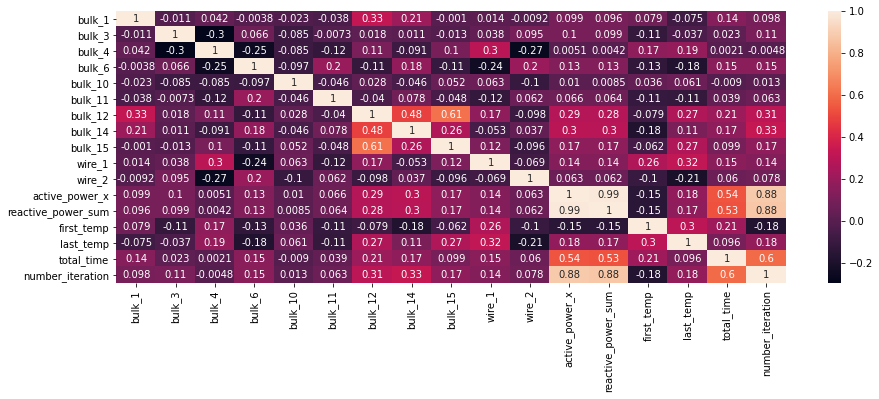

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data_final.corr(), annot = True)

In [61]:
data_final = data_final.drop('reactive_power_sum', axis=1)

В призанках присутствует коллинеарность. Высокая корреляция между reactive_power_sum и active_power_sum. reactive_power_sum необбходимо удалить

In [62]:
#Определение признаков
features = data_final.drop('last_temp', axis=1)
target = data_final['last_temp']

In [63]:
RANDOM_STATE = 50623

In [64]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE,
                                                                            shuffle = True)
features_train.head()

,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,active_power_x,first_temp,total_time,number_iteration
1293,0.0,94.0,0.0,0.0,0.0,0.0,255.0,101.0,204.0,129.027587,55.343597,2.115356,1589.0,1589.0,4
1053,0.0,0.0,77.0,0.0,0.0,0.0,364.0,203.0,208.0,139.183196,0.000000,4.443630,1600.0,3126.0,6
1268,0.0,67.0,0.0,226.0,0.0,0.0,409.0,337.0,211.0,45.021599,0.000000,3.570249,1552.0,4312.0,4
45,0.0,0.0,0.0,172.0,0.0,0.0,0.0,0.0,0.0,72.203041,47.145283,3.548490,1573.0,1509.0,5
1322,27.0,122.0,55.0,0.0,0.0,0.0,465.0,231.0,103.0,136.188005,0.000000,2.714637,1570.0,1785.0,5


In [65]:
#Масштабирование признаков для линейной модели
scaler= StandardScaler()
features_train_lr = scaler.fit_transform(features_train)
features_test_lr = scaler.transform(features_test)

In [66]:
print('Размеры обучающей выборки', features_train.shape)
print('Размеры тестовой выборки', features_test.shape)

Размеры обучающей выборки (1743, 15)
Размеры тестовой выборки (582, 15)


# 4. Обучение моделей

## 4.1 Константная модель

In [67]:
target_train.median()

1593.0

In [68]:
predicion_model_constant = pd.Series([target_test.median()] * len(target_test))

In [69]:
print(f'MAE на константной модели: {mean_absolute_error(target_test, predicion_model_constant)}')

MAE на константной модели: 8.073883161512027


## 4.2 Линейная Регрессия

In [70]:
model_lr = LinearRegression().fit(features_train_lr, target_train)

In [71]:
model_lr_mae_cv = cross_validate(model_lr, features_train, target_train, scoring='neg_mean_absolute_error')['test_score'].mean()*-1

In [72]:
model_lr.coef_

array([-1.892081  , -0.08365419,  0.14321916, -0.89958425,  0.11191753,
       -0.42295117,  1.95774087,  0.73615102,  1.09384246,  1.34742592,
       -1.31498689,  0.70639239,  4.32761342, -1.65391981,  2.46692562])

## 4.3 Случайный лес

In [74]:
def rf_objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 10,200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 100) 
    model_rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators,
                                           min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                                           random_state=RANDOM_STATE)

    scores = cross_val_score(model_rf, features_train, target_train, scoring='neg_mean_absolute_error')
    
    return scores.mean()
    
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=30)
rf_study.best_value

[I 2023-06-09 13:29:01,265] A new study created in memory with name: no-name-125192b5-43d2-4b97-9a8f-0570d139a06b
[I 2023-06-09 13:29:05,123] Trial 0 finished with value: -7.2259074791749835 and parameters: {'n_estimators': 277, 'max_depth': 49, 'min_samples_leaf': 71, 'min_samples_split': 7}. Best is trial 0 with value: -7.2259074791749835.
[I 2023-06-09 13:29:05,554] Trial 1 finished with value: -7.280284017424757 and parameters: {'n_estimators': 30, 'max_depth': 126, 'min_samples_leaf': 88, 'min_samples_split': 81}. Best is trial 0 with value: -7.2259074791749835.
[I 2023-06-09 13:29:06,801] Trial 2 finished with value: -7.064423417895503 and parameters: {'n_estimators': 64, 'max_depth': 168, 'min_samples_leaf': 21, 'min_samples_split': 66}. Best is trial 2 with value: -7.064423417895503.
[I 2023-06-09 13:29:10,200] Trial 3 finished with value: -7.034541353936598 and parameters: {'n_estimators': 175, 'max_depth': 197, 'min_samples_leaf': 17, 'min_samples_split': 64}. Best is trial 3

-6.934364896213253

In [75]:
rf_study.best_params

{'n_estimators': 207,
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 30}

### 4.3 CatBoost

In [76]:
catboost = CatBoostRegressor(iterations=160, learning_rate=0.08, verbose=3)
cv_cb= cross_validate(catboost, features_train, target_train, scoring='neg_mean_absolute_error')

0:	learn: 11.1002419	total: 50.3ms	remaining: 8s
3:	learn: 10.6039893	total: 58.6ms	remaining: 2.29s
6:	learn: 10.1830964	total: 66.6ms	remaining: 1.46s
9:	learn: 9.8449028	total: 73.7ms	remaining: 1.1s
12:	learn: 9.5937540	total: 80.7ms	remaining: 912ms
15:	learn: 9.3536461	total: 87.6ms	remaining: 789ms
18:	learn: 9.2115413	total: 94.5ms	remaining: 701ms
21:	learn: 9.0556951	total: 101ms	remaining: 634ms
24:	learn: 8.9225919	total: 108ms	remaining: 582ms
27:	learn: 8.8046311	total: 115ms	remaining: 541ms
30:	learn: 8.7069768	total: 122ms	remaining: 507ms
33:	learn: 8.6210776	total: 129ms	remaining: 478ms
36:	learn: 8.5580201	total: 136ms	remaining: 452ms
39:	learn: 8.4748553	total: 143ms	remaining: 429ms
42:	learn: 8.3961727	total: 150ms	remaining: 409ms
45:	learn: 8.3015564	total: 158ms	remaining: 391ms
48:	learn: 8.2386862	total: 165ms	remaining: 373ms
51:	learn: 8.1612483	total: 171ms	remaining: 356ms
54:	learn: 8.1149964	total: 178ms	remaining: 339ms
57:	learn: 8.0595957	total: 1

In [77]:
cv_cb['test_score'].mean()

-6.778599937869603

In [78]:
pd.DataFrame({'Качество модели MAE':[model_lr_mae_cv,rf_study.best_value*-1,cv_cb['test_score'].mean()*-1]},
            index=['Линейная регрессия', 'Случайный лес', 'CatBoost'])

,Качество модели MAE
Линейная регрессия,6.947913
Случайный лес,6.934365
CatBoost,6.778600


In [85]:
model_catboost = CatBoostRegressor(iterations=160, learning_rate=0.08, verbose=3).fit(features_train, target_train)

0:	learn: 10.9816224	total: 3.2ms	remaining: 509ms
3:	learn: 10.4690367	total: 11.8ms	remaining: 459ms
6:	learn: 10.0692527	total: 20.3ms	remaining: 443ms
9:	learn: 9.7558413	total: 28.5ms	remaining: 427ms
12:	learn: 9.5319598	total: 40.6ms	remaining: 460ms
15:	learn: 9.3057229	total: 54.3ms	remaining: 489ms
18:	learn: 9.1277979	total: 67.4ms	remaining: 500ms
21:	learn: 8.9762699	total: 76.7ms	remaining: 481ms
24:	learn: 8.8561193	total: 87.1ms	remaining: 470ms
27:	learn: 8.7340350	total: 95.6ms	remaining: 451ms
30:	learn: 8.6257611	total: 104ms	remaining: 432ms
33:	learn: 8.5418155	total: 112ms	remaining: 414ms
36:	learn: 8.4548220	total: 120ms	remaining: 399ms
39:	learn: 8.3829302	total: 128ms	remaining: 384ms
42:	learn: 8.3198907	total: 136ms	remaining: 371ms
45:	learn: 8.2500875	total: 144ms	remaining: 358ms
48:	learn: 8.1957846	total: 152ms	remaining: 345ms
51:	learn: 8.1342168	total: 160ms	remaining: 333ms
54:	learn: 8.0826026	total: 168ms	remaining: 321ms
57:	learn: 8.0470635	to

Text(0.5, 1.0, 'Важность признаков')

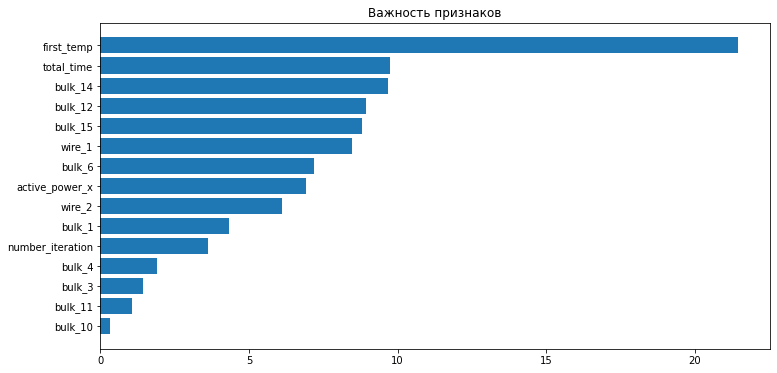

In [96]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Важность признаков')


Наилучший показатель при кросс-валидации у модели catboost, mae=6.78. Линейная регрессия и случайный лес находятся на одном уровне. Самым важным призанком является начальная температура. Наименее важным является bulk10

# 5. Проверка моделей на тестовой выборке

In [74]:
#функция для расчёта MAE
def mae_calculate(model, test_features, test_target):
    return mean_absolute_error(test_target, model.predict(test_features))

In [75]:
model_catboost = CatBoostRegressor(iterations=160, learning_rate=0.08, verbose=3).fit(features_train, target_train)

0:	learn: 10.9816224	total: 53.4ms	remaining: 8.49s
3:	learn: 10.4690367	total: 68.1ms	remaining: 2.65s
6:	learn: 10.0692527	total: 81.9ms	remaining: 1.79s
9:	learn: 9.7558413	total: 148ms	remaining: 2.22s
12:	learn: 9.5319598	total: 161ms	remaining: 1.82s
15:	learn: 9.3057229	total: 174ms	remaining: 1.56s
18:	learn: 9.1277979	total: 238ms	remaining: 1.76s
21:	learn: 8.9762699	total: 252ms	remaining: 1.58s
24:	learn: 8.8561193	total: 264ms	remaining: 1.43s
27:	learn: 8.7340350	total: 277ms	remaining: 1.3s
30:	learn: 8.6257611	total: 289ms	remaining: 1.2s
33:	learn: 8.5418155	total: 302ms	remaining: 1.12s
36:	learn: 8.4548220	total: 316ms	remaining: 1.05s
39:	learn: 8.3829302	total: 381ms	remaining: 1.14s
42:	learn: 8.3198907	total: 395ms	remaining: 1.07s
45:	learn: 8.2500875	total: 409ms	remaining: 1.01s
48:	learn: 8.1957846	total: 422ms	remaining: 956ms
51:	learn: 8.1342168	total: 488ms	remaining: 1.01s
54:	learn: 8.0826026	total: 502ms	remaining: 958ms
57:	learn: 8.0470635	total: 515

In [76]:
pd.DataFrame({'Качество модели MAE на тесте':[mae_calculate(model_catboost, features_test, target_test)]},
            index=['CatBoost'])

,Качество модели MAE на тесте
CatBoost,6.7541


<b>Вывод:</b>
   - Наилучший показатель на тестовой выборки у модели catboost. Для расчёта конечной температуры заказчику необходимо использовать модель catboost MAE < 6.8.